In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nplab.datafile as df
import scipy.signal as sig
import scipy.constants as const
import peakutils
import numpy as np
import datetime
from peakutils.plot import plot as pplot
from parula import cm_data
from matplotlib.colors import LinearSegmentedColormap 
from matplotlib.collections import LineCollection
import os
import Alexsdatafuncs
import matplotlib.cm as cm
import time

In [2]:
parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
copper_map = LinearSegmentedColormap.from_list('copper', cm_data)

Alex_data = Alexsdatafuncs.data_manipulators()
Alex_plot = Alexsdatafuncs.plotting_funcs()

In [3]:
#    
def big_for(filelist, start_time, finish_time, max_peaks = 7, wavelength_start = 405, wavelength_end = 1000, 
            peakfind_start = 401):
    
    wavelengthvals = filelist[filelist.keys()[0]].attrs['wavelengths']
    data_start = (np.abs(wavelengthvals - wavelength_start)).argmin()
    data_end = (np.abs(wavelengthvals - wavelength_end)).argmin()
    peak_data_start = (np.abs(wavelengthvals - peakfind_start)).argmin()
    data_range = data_end - data_start
    peak_index_store = []
    wavelength_store = []
    name_store = []
    intensity_store_norm = []
    intensity_store = []
    peak_wavelengths_store = []
    peak_intensities_store = []
    min_indexes = []
    min_index_store = []
    min_wavelengths_store = []
    min_intensities_store = []
    
    #Search for reference spectrum   
    try:
        for i in range(0, len(filelist)):
            try:
                ref = filelist[filelist.keys()[i]].attrs['reference']
                print "Reference spectrum taken from spectrum: " 
                print filelist.keys()[i]
                break
            except KeyError:
                ref = filelist[filelist.keys()[0]]
                pass
    except KeyError:
        print """Coudn't find a stored reference attribute, \n
        find the file containing a reference and paste this into the code"""
        ref = filelist[filelist.keys()[0]]
    
    back = filelist[filelist.keys()[0]].attrs['background']
    x = wavelengthvals

    slash_loc = Alex_data.slashfinder(fname)

    spectrum_indexes = []
    num_peaks_store = []
    intensity_initial_peak_store = []
    initial_peak_wl_store = []
    second_peak_wl_store = []

    peak_width_guess = 50
    exp_number_of_peaks = 2

    no_spectra=-1

    for data_set in filelist.values():

        current_timestamp =  datetime.datetime.strptime(
                data_set.attrs['creation_timestamp'][:19], "%Y-%m-%dT%H:%M:%S")

        no_spectra += 1

        if current_timestamp >= start_time and current_timestamp <= finish_time:

            print "Current spectrum: " + data_set.name[25:]

            spectrum_indexes = np.append(spectrum_indexes, [no_spectra])

            y_raw = np.array(data_set.value)
            y = (y_raw-back)/(ref-back)

            y_red = y[data_start:data_end]
            x_red = x[data_start:data_end]

            #Use Savitsky-Golay noise filter to remove noise if chosen


            y_filtered = sig.savgol_filter(y_red,23,3)
            y_filtered_corr = y_filtered - min(y_filtered)
            y_norm = (y_filtered_corr/max(y_filtered_corr))
            y_red = y_filtered
    #         else:
    #             y_red = y[data_start:data_end] - min(y[data_start:data_end])
    #             y_norm = (y_red/max(y_red))
    #             pass

            #Set peakfinder to only search above set wavelength value with 
            #peak_data_start

            #Automatically search for the correct threshold leading the code to 
            #find the defined number of peaks
            thresh_guess = 0.5
            find_peaks = False
            while find_peaks == False and exp_number_of_peaks != 0:
                peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                if len(peak_indexes) >= exp_number_of_peaks:
                    find_peaks = True
                elif thresh_guess <=0.01:
                    while find_peaks == False:
                        peak_indexes = peakutils.indexes(y_norm[peak_data_start:data_end], 
                                                         thres = thresh_guess, 
                                                         min_dist = peak_width_guess*2)
                        min_indexes = peakutils.indexes(-1*y_norm[peak_data_start:data_end], 
                                                 thres = thresh_guess, 
                                                 min_dist = peak_width_guess*2)
                        if len(peak_indexes) >= exp_number_of_peaks:
                            find_peaks = True
                        elif thresh_guess > 1:
                            print "Didn't find threshold for spectrum" + str(no_spectra)
                            print "Need to change expected number or peaks"
                            thresh_guess = 0.5
                            break
                        else:
                            thresh_guess += 0.01
                    break
                else:
                    thresh_guess -= 0.01

            peak_indexes = peak_indexes + peak_data_start
            min_indexes = min_indexes + peak_data_start
            peak_indexes_orig = peak_indexes
            num_peaks = len(peak_indexes_orig)
            
            #Crop and add points to minima peaks
            if len(min_indexes) > max_peaks:
                while len(min_indexes) > max_peaks:
                    min_indexes = np.delete(min_indexes,[max_peaks])
            elif len(min_indexes) < max_peaks:
                while len(min_indexes) < max_peaks:
                    min_indexes = np.append(min_indexes,[0])
            else:
                pass
            
            #Crop and add 0 to peaks
            if len(peak_indexes) > max_peaks:
                while len(peak_indexes) > max_peaks:
                    peak_indexes = np.delete(peak_indexes,[max_peaks])
            elif len(peak_indexes) < max_peaks:
                while len(peak_indexes) < max_peaks:
                    peak_indexes = np.append(peak_indexes,[0])
            else:
                pass

            peak_wavelengths = []
            min_wavelengths = []
            peak_intensities = []
            min_intensities = []
            for i in range(0,max_peaks):
                if peak_indexes[i] != 0:
                    peak_wavelengths = np.append(peak_wavelengths, 
                                                 [x_red[peak_indexes[i]]])
                else:
                    peak_wavelengths = np.append(peak_wavelengths, [0])
                    
                if peak_indexes[i] != 0:
                    peak_intensities = np.append(peak_intensities, 
                                                 [y_norm[peak_indexes[i]]])
                else:
                    peak_intensities = np.append(peak_intensities, [0])
                    
                if min_indexes[i] != 0:
                    min_wavelengths = np.append(min_wavelengths, 
                                                 [x_red[min_indexes[i]]])
                else:
                    min_wavelengths = np.append(min_wavelengths, [0])
                    
                if min_indexes[i] != 0:
                    min_intensities = np.append(min_intensities, 
                                                 [y_norm[min_indexes[i]]])
                else:
                    min_intensities = np.append(min_intensities, [0])

    
                

            #Gaussian fitting    

    #         try:
    #             multi_gauss_fit_a = Alex_data.gaussian_fit_2(y_norm, x_red, 
    #                                                          peak_indexes_orig, 
    #                                                          peak_intensities)
    #         except UnboundLocalError:
    #             print "Gauss fit didnt work for spectrum" + str(no_spectra) 
    #             pass
    #         else:
    #             pass

            wavelength_store.append(x_red)
            name_store.append(data_set.name[25:])
            intensity_store.append(y_red)
            intensity_store_norm.append(y_norm)
            peak_index_store.append(peak_indexes)
            min_index_store.append(min_indexes)
            peak_wavelengths_store.append(peak_wavelengths)
            peak_intensities_store.append(peak_intensities)
            min_wavelengths_store.append(min_wavelengths)
            min_intensities_store.append(min_intensities)
            num_peaks_store = np.append(num_peaks_store, num_peaks)
            intensity_initial_peak_store = np.append(intensity_initial_peak_store, 
                                                     peak_intensities[0])
            initial_peak_wl_store = np.append(initial_peak_wl_store,peak_wavelengths[0])
            second_peak_wl_store = np.append(second_peak_wl_store, peak_wavelengths[1])

        else:
            pass
        
    wavelength_store = np.array(wavelength_store)        
    intensity_store = np.array(intensity_store)
    name_store = np.array(name_store)
    intensity_store_norm = np.array(intensity_store_norm)
    peak_index_store = np.array(peak_index_store)
    min_index_store = np.array(min_index_store)
    min_wavelengths_store = np.array(min_wavelengths_store)
    min_intensities_store = np.array(min_intensities_store)
    peak_wavelengths_store = np.array(peak_wavelengths_store)
    peak_intensities_store = np.array(peak_intensities_store)
    num_peaks_store = np.array(num_peaks_store)
    intensity_initial_peak_store = np.array(intensity_initial_peak_store)
    initial_peak_wl_store = np.array(initial_peak_wl_store)
    second_peak_wl_store = np.array(second_peak_wl_store)
    
    return wavelength_store, intensity_store, name_store, intensity_store_norm, peak_index_store, peak_wavelengths_store,peak_intensities_store, num_peaks_store, intensity_initial_peak_store,initial_peak_wl_store, second_peak_wl_store, min_index_store, min_wavelengths_store, min_intensities_store  


In [4]:
#Calculate useful values
def val_calc(num_peaks_store, second_peak_wl_store, initial_peak_wl_store, wavelength_store, 
             intensity_initial_peak_store, intensity_store_norm, intensity_store, av_init_peak_pos = 660):
    av_num_peaks = np.mean(num_peaks_store)
    av_second_peak_pos = np.mean(second_peak_wl_store)
    av_init_peak_pos_stddev = np.std(initial_peak_wl_store)
    av_second_peak_pos_stdev = np.std(second_peak_wl_store)
    av_init_peak_pos = 660

    init_peak = []
    second_peak = []
    for i in range(0, len(initial_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_init_peak_pos + av_init_peak_pos_stddev):
            init_peak = np.append(init_peak, initial_peak_wl_store[i])
        else:
            pass
    av_init_peak = np.mean(init_peak)
    for i in range(0, len(second_peak_wl_store)): 
        if initial_peak_wl_store[i] < (av_second_peak_pos + av_second_peak_pos_stdev):
            second_peak = np.append(second_peak, second_peak_wl_store[i])
        else:
            pass
    # if answers[6] == True:    
    #     ax1.plot([av_init_peak]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    #     ax1.plot([av_second_peak_pos]*len(np.linspace(64,70)), np.linspace(64,70),'r--')
    # else:
    #     pass

    av_init_peak_intensities = np.mean(intensity_initial_peak_store)
    average_all_intensities_norm = np.mean(intensity_store_norm, axis=0)
    average_all_intensities = np.mean(intensity_store, axis=0)
    av_stddev_norm = (np.std((intensity_store_norm), axis=0, dtype = np.float64))/np.sqrt(len(wavelength_store))
    av_stddev = np.std((intensity_store), axis=0, dtype = np.float64)/np.sqrt(len(wavelength_store))


    min_peak_pos_av = wavelength_store[0][np.argmin(average_all_intensities_norm)]

    return av_init_peak_intensities, average_all_intensities_norm, average_all_intensities, av_stddev_norm, av_stddev, min_peak_pos_av

In [5]:
cd C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator

C:\Users\alexc\OneDrive - University Of Cambridge\Documents\PhD Project\Projects\Hot electron resonator


In [22]:
data_f.close()

In [23]:
data_f = df.current()
fname = data_f.filename

No current data file, attempting to create...
C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/2018-08-24_5.8nm_2.7nm_NPoM_TiO2_Al_resonator.h5
opening file:  C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/2018-08-24_5.8nm_2.7nm_NPoM_TiO2_Al_resonator.h5


In [24]:
filelist_DF = data_f['OceanOpticsSpectrometer']
camlist_DF = data_f['LumeneraCamera']

In [18]:
#5.8nm TiO2 60nm NPs before second growth
start_time_5_8nm = datetime.datetime.strptime('2018-06-04T09:23:53.515000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_5_8nm = datetime.datetime.strptime('2018-06-04T09:52:06.476000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#5.8nm TiO2 60nm NPs after second growth
start_time_5_8nm_1 = datetime.datetime.strptime('2018-07-13T13:45:33.526000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_5_8nm_1 = datetime.datetime.strptime('2018-07-13T15:17:22.803000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#5.8nm TiO2 60nm NPs after Au dep
start_time_5_8nm_Au = datetime.datetime.strptime('2018-08-24T14:53:53.417000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_5_8nm_Au = datetime.datetime.strptime('2018-08-24T15:50:05.598000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#5.8nm TiO2 60nm NPs after Al dep
start_time_5_8nm_Al = datetime.datetime.strptime('2018-08-24T13:28:59.720000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_5_8nm_Al = datetime.datetime.strptime('2018-08-24T13:46:23.777000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [19]:
#2.7nmnm TiO2 60nm NPs before second growth
start_time_2_7nm = datetime.datetime.strptime('2018-06-04T09:52:06.476000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_2_7nm = datetime.datetime.strptime('2018-06-04T10:22:05.455000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#2.7nmnm TiO2 60nm NPs after second growth first range
start_time_2_7nm_1 = datetime.datetime.strptime('2018-07-13T15:31:59.383000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_2_7nm_1 = datetime.datetime.strptime('2018-07-13T16:17:08.519000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#2.7nm TiO2 60nm NPs after Al dep                                               
start_time_2_7nm_Au = datetime.datetime.strptime('2018-08-24T14:15:24.299000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_2_7nm_Au = datetime.datetime.strptime('2018-08-24T14:48:31.403000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
#2.7nm TiO2 60nm NPs after Al dep
start_time_2_7nm_Al = datetime.datetime.strptime('2018-08-24T11:41:39.387000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")
finish_time_2_7nm_Al = datetime.datetime.strptime('2018-08-24T13:25:43.712000', 
                                        "%Y-%m-%dT%H:%M:%S.%f")

In [81]:
#Data analysis for TiO2 spacer only
wavelength_store_5_8nm, intensity_store_5_8nm, name_store_5_8nm, intensity_store_norm_5_8nm, \
peak_index_store_5_8nm, peak_wavelengths_store_5_8nm, peak_intensities_store_5_8nm, num_peaks_store_5_8nm,\
intensity_initial_peak_store_5_8nm, initial_peak_wl_store_5_8nm,\
second_peak_wl_store_5_8nm, min_indexes_store_5_8nm, \
min_wavelengths_store_5_8nm, min_intensities_store_5_8nm = big_for(filelist = filelist_DF, start_time = start_time_5_8nm, finish_time = finish_time_5_8nm, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
2.7nm_TiO2_NP100_0
Current spectrum: 5.8nm_TiO2_NP100_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: 5.8nm_TiO2_NP10_0
Current spectrum: 5.8nm_TiO2_NP11_0
Current spectrum: 5.8nm_TiO2_NP12_0
Current spectrum: 5.8nm_TiO2_NP13_0
Current spectrum: 5.8nm_TiO2_NP14_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


Current spectrum: 5.8nm_TiO2_NP15_0
Current spectrum: 5.8nm_TiO2_NP16_0
Current spectrum: 5.8nm_TiO2_NP17_0
Current spectrum: 5.8nm_TiO2_NP18_0
Current spectrum: 5.8nm_TiO2_NP19_0
Current spectrum: 5.8nm_TiO2_NP20_0
Current spectrum: 5.8nm_TiO2_NP21_0
Current spectrum: 5.8nm_TiO2_NP22_0
Current spectrum: 5.8nm_TiO2_NP23_0
Current spectrum: 5.8nm_TiO2_NP24_0
Current spectrum: 5.8nm_TiO2_NP25_0
Current spectrum: 5.8nm_TiO2_NP26_0
Current spectrum: 5.8nm_TiO2_NP27_0
Current spectrum: 5.8nm_TiO2_NP28_0
Current spectrum: 5.8nm_TiO2_NP29_0
Current spectrum: 5.8nm_TiO2_NP2_0
Current spectrum: 5.8nm_TiO2_NP30_0
Current spectrum: 5.8nm_TiO2_NP31_0
Current spectrum: 5.8nm_TiO2_NP32_0
Current spectrum: 5.8nm_TiO2_NP33_0
Current spectrum: 5.8nm_TiO2_NP34_0
Current spectrum: 5.8nm_TiO2_NP35_0
Current spectrum: 5.8nm_TiO2_NP36_0
Current spectrum: 5.8nm_TiO2_NP37_0
Current spectrum: 5.8nm_TiO2_NP38_0
Current spectrum: 5.8nm_TiO2_NP39_0
Current spectrum: 5.8nm_TiO2_NP3_0
Current spectrum: 5.8nm_TiO2_N

In [82]:
#Data analysis for TiO2 spacer only
wavelength_store_2_7nm, intensity_store_2_7nm, name_store_2_7nm, intensity_store_norm_2_7nm, \
peak_index_store_2_7nm, peak_wavelengths_store_2_7nm, peak_intensities_store_2_7nm, num_peaks_store_2_7nm,\
intensity_initial_peak_store_2_7nm, initial_peak_wl_store_2_7nm,\
second_peak_wl_store_2_7nm, min_indexes_store_2_7nm, \
min_wavelengths_store_2_7nm, min_intensities_store_2_7nm = big_for(filelist = filelist_DF, start_time = start_time_2_7nm, finish_time = finish_time_2_7nm, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
2.7nm_TiO2_NP100_0
Current spectrum: 2.7nm_TiO2_NP100_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: 2.7nm_TiO2_NP10_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


Current spectrum: 2.7nm_TiO2_NP11_0
Current spectrum: 2.7nm_TiO2_NP12_0
Current spectrum: 2.7nm_TiO2_NP13_0
Current spectrum: 2.7nm_TiO2_NP14_0
Current spectrum: 2.7nm_TiO2_NP15_0
Current spectrum: 2.7nm_TiO2_NP16_0
Current spectrum: 2.7nm_TiO2_NP17_0
Current spectrum: 2.7nm_TiO2_NP18_0
Current spectrum: 2.7nm_TiO2_NP1_0
Current spectrum: 2.7nm_TiO2_NP20_0
Current spectrum: 2.7nm_TiO2_NP21_0
Current spectrum: 2.7nm_TiO2_NP22_0
Current spectrum: 2.7nm_TiO2_NP23_0
Current spectrum: 2.7nm_TiO2_NP24_0
Current spectrum: 2.7nm_TiO2_NP25_0
Current spectrum: 2.7nm_TiO2_NP26_0
Current spectrum: 2.7nm_TiO2_NP27_0
Current spectrum: 2.7nm_TiO2_NP28_0
Current spectrum: 2.7nm_TiO2_NP29_0
Current spectrum: 2.7nm_TiO2_NP2_0
Current spectrum: 2.7nm_TiO2_NP30_0
Current spectrum: 2.7nm_TiO2_NP31_0
Current spectrum: 2.7nm_TiO2_NP32_0
Current spectrum: 2.7nm_TiO2_NP33_0
Current spectrum: 2.7nm_TiO2_NP34_0
Current spectrum: 2.7nm_TiO2_NP35_0
Current spectrum: 2.7nm_TiO2_NP36_0
Current spectrum: 2.7nm_TiO2_N

In [57]:
#Analysis for 2.7nm Tio2 with 7nm on top
wavelength_store_2_7nm_1, intensity_store_2_7nm_1, name_store_2_7nm_1, intensity_store_norm_2_7nm_1, \
peak_index_store_2_7nm_1, peak_wavelengths_store_2_7nm_1, peak_intensities_store_2_7nm_1, num_peaks_store_2_7nm_1,\
intensity_initial_peak_store_2_7nm_1, initial_peak_wl_store_2_7nm_1,\
second_peak_wl_store_2_7nm_1, min_indexes_store_2_7nm_1, \
min_wavelengths_store_2_7nm_1, min_intensities_store_2_7nm_1 = big_for(filelist = filelist_DF, start_time = start_time_2_7nm_1, finish_time = finish_time_2_7nm_1, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
BG_0
Current spectrum: BG_0
Current spectrum: NP10_0
Current spectrum: NP11_0
Current spectrum: NP12_0
Current spectrum: NP13_0
Current spectrum: NP14_0
Current spectrum: NP15_0
Current spectrum: NP16_0
Current spectrum: NP17_0
Current spectrum: NP18_0
Current spectrum: NP19_0
Current spectrum: NP1_1
Current spectrum: NP20_0
Current spectrum: NP21_0
Current spectrum: NP22_0
Current spectrum: NP23_0
Current spectrum: NP24_0
Current spectrum: NP25_0
Current spectrum: NP26_0
Current spectrum: NP27_0
Current spectrum: NP28_0
Current spectrum: NP29_0
Current spectrum: NP2_0
Current spectrum: NP30_0
Current spectrum: NP31_0
Current spectrum: NP32_0
Current spectrum: NP33_0
Current spectrum: NP34_0
Current spectrum: NP35_0
Current spectrum: NP36_0
Current spectrum: NP37_0
Current spectrum: NP38_0
Current spectrum: NP39_0
Current spectrum: NP3_0
Current spectrum: NP40_0
Current spectrum: NP41_0
Current spectrum: NP42_0
Current spectrum: NP43_0
Current s

In [71]:
#Analysis for 5.8nm Tio2 with 7nm on top
wavelength_store_5_8nm_1, intensity_store_5_8nm_1, name_store_5_8nm_1, intensity_store_norm_5_8nm_1, \
peak_index_store_5_8nm_1, peak_wavelengths_store_5_8nm_1, peak_intensities_store_5_8nm_1, num_peaks_store_5_8nm_1,\
intensity_initial_peak_store_5_8nm_1, initial_peak_wl_store_5_8nm_1,\
second_peak_wl_store_5_8nm_1, min_indexes_store_5_8nm_1, \
min_wavelengths_store_5_8nm_1, min_intensities_store_5_8nm_1 = big_for(filelist = filelist_DF, start_time = start_time_5_8nm_1, finish_time = finish_time_5_8nm_1, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Agg_1_0
Current spectrum: Agg_1_0
Current spectrum: NP100_0
Current spectrum: NP101_0
Current spectrum: NP102_0
Current spectrum: NP103_0
Current spectrum: NP104_0
Current spectrum: NP105_0
Current spectrum: NP106_0
Current spectrum: NP107_0
Current spectrum: NP108_0
Current spectrum: NP109_0
Current spectrum: NP10_0
Current spectrum: NP110_0
Current spectrum: NP111_0
Current spectrum: NP112_0
Current spectrum: NP113_0
Current spectrum: NP114_0
Current spectrum: NP115_0
Current spectrum: NP116_0
Current spectrum: NP117_0
Current spectrum: NP118_0
Current spectrum: NP119_0
Current spectrum: NP11_0
Current spectrum: NP120_0
Current spectrum: NP121_0
Current spectrum: NP122_0
Current spectrum: NP123_0
Current spectrum: NP124_0
Current spectrum: NP125_0
Current spectrum: NP126_0
Current spectrum: NP127_0
Current spectrum: NP128_0
Current spectrum: NP129_0
Current spectrum: NP12_0
Current spectrum: NP130_0
Current spectrum: NP131_0
Current spectrum: 

In [25]:
#Analysis for further 10nm Al on top of 5.8nm
wavelength_store_5_8nm_Al, intensity_store_5_8nm_Al, name_store_5_8nm_Al, intensity_store_norm_5_8nm_Al, \
peak_index_store_5_8nm_Al, peak_wavelengths_store_5_8nm_Al, peak_intensities_store_5_8nm_Al, num_peaks_store_5_8nm_Al,\
intensity_initial_peak_store_5_8nm_Al, initial_peak_wl_store_5_8nm_Al,\
second_peak_wl_store_5_8nm_Al, min_indexes_store_5_8nm_Al, \
min_wavelengths_store_5_8nm_Al, min_intensities_store_5_8nm_Al = big_for(filelist = filelist_DF, start_time = start_time_5_8nm_Al, finish_time = finish_time_5_8nm_Al, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)


Reference spectrum taken from spectrum: 
2.7nm_Al_0
Current spectrum: reg1_5.8nm_Al_1
Current spectrum: reg1_5.8nm_Al_10
Current spectrum: reg1_5.8nm_Al_100
Current spectrum: reg1_5.8nm_Al_101
Current spectrum: reg1_5.8nm_Al_102
Current spectrum: reg1_5.8nm_Al_103
Current spectrum: reg1_5.8nm_Al_104
Current spectrum: reg1_5.8nm_Al_105
Current spectrum: reg1_5.8nm_Al_106
Current spectrum: reg1_5.8nm_Al_107
Current spectrum: reg1_5.8nm_Al_108
Current spectrum: reg1_5.8nm_Al_109
Current spectrum: reg1_5.8nm_Al_11
Current spectrum: reg1_5.8nm_Al_110
Current spectrum: reg1_5.8nm_Al_111
Current spectrum: reg1_5.8nm_Al_112
Current spectrum: reg1_5.8nm_Al_113
Current spectrum: reg1_5.8nm_Al_114
Current spectrum: reg1_5.8nm_Al_115
Current spectrum: reg1_5.8nm_Al_116
Current spectrum: reg1_5.8nm_Al_117
Current spectrum: reg1_5.8nm_Al_118
Current spectrum: reg1_5.8nm_Al_12
Current spectrum: reg1_5.8nm_Al_13
Current spectrum: reg1_5.8nm_Al_14
Current spectrum: reg1_5.8nm_Al_15
Current spectrum: re

In [28]:
#Analysis for further 10nm Al on top of 2.7nm
wavelength_store_2_7nm_Al, intensity_store_2_7nm_Al, name_store_2_7nm_Al, intensity_store_norm_2_7nm_Al, \
peak_index_store_2_7nm_Al, peak_wavelengths_store_2_7nm_Al, peak_intensities_store_2_7nm_Al, num_peaks_store_2_7nm_Al,\
intensity_initial_peak_store_2_7nm_Al, initial_peak_wl_store_2_7nm_Al,\
second_peak_wl_store_2_7nm_Al, min_indexes_store_2_7nm_Al, \
min_wavelengths_store_2_7nm_Al, min_intensities_store_2_7nm_Al = big_for(filelist = filelist_DF, start_time = start_time_2_7nm_Al, finish_time = finish_time_2_7nm_Al, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
2.7nm_Al_0
Current spectrum: 2.7nm_Al_0
Current spectrum: 2.7nm_Al_1
Current spectrum: 2.7nm_Al_10
Current spectrum: 2.7nm_Al_100
Current spectrum: 2.7nm_Al_101
Current spectrum: 2.7nm_Al_102
Current spectrum: 2.7nm_Al_103
Current spectrum: 2.7nm_Al_104
Current spectrum: 2.7nm_Al_105
Current spectrum: 2.7nm_Al_106
Current spectrum: 2.7nm_Al_107
Current spectrum: 2.7nm_Al_108
Current spectrum: 2.7nm_Al_109
Current spectrum: 2.7nm_Al_11
Current spectrum: 2.7nm_Al_110
Current spectrum: 2.7nm_Al_111
Current spectrum: 2.7nm_Al_112
Current spectrum: 2.7nm_Al_113
Current spectrum: 2.7nm_Al_114
Current spectrum: 2.7nm_Al_115
Current spectrum: 2.7nm_Al_12
Current spectrum: 2.7nm_Al_13
Current spectrum: 2.7nm_Al_14
Current spectrum: 2.7nm_Al_15
Current spectrum: 2.7nm_Al_16
Current spectrum: 2.7nm_Al_17
Current spectrum: 2.7nm_Al_18
Current spectrum: 2.7nm_Al_19
Current spectrum: 2.7nm_Al_2
Current spectrum: 2.7nm_Al_20
Current spectrum: 2.7nm_Al_21
Curre

In [38]:
#Analysis for further 10nm Au on top of 5.8nm
wavelength_store_5_8nm_Au, intensity_store_5_8nm_Au, name_store_5_8nm_Au, intensity_store_norm_5_8nm_Au, \
peak_index_store_5_8nm_Au, peak_wavelengths_store_5_8nm_Au, peak_intensities_store_5_8nm_Au, num_peaks_store_5_8nm_Au,\
intensity_initial_peak_store_5_8nm_Au, initial_peak_wl_store_5_8nm_Au,\
second_peak_wl_store_5_8nm_Au, min_indexes_store_5_8nm_Au, \
min_wavelengths_store_5_8nm_Au, min_intensities_store_5_8nm_Au = big_for(filelist = filelist_DF, start_time = start_time_5_8nm_Au, finish_time = finish_time_5_8nm_Au, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

#Analysis for further 10nm Au on top of 2.7nm
wavelength_store_2_7nm_Au, intensity_store_2_7nm_Au, name_store_2_7nm_Au, intensity_store_norm_2_7nm_Au, \
peak_index_store_2_7nm_Au, peak_wavelengths_store_2_7nm_Au, peak_intensities_store_2_7nm_Au, num_peaks_store_2_7nm_Au,\
intensity_initial_peak_store_2_7nm_Au, initial_peak_wl_store_2_7nm_Au,\
second_peak_wl_store_2_7nm_Au, min_indexes_store_2_7nm_Au, \
min_wavelengths_store_2_7nm_Au, min_intensities_store_2_7nm_Au = big_for(filelist = filelist_DF, start_time = start_time_2_7nm_Au, finish_time = finish_time_2_7nm_Au, max_peaks = 7, 
          wavelength_start = 405,wavelength_end = 1000, peakfind_start = 401)

Reference spectrum taken from spectrum: 
Region1_5.8nm_Au_red_bg_0
Current spectrum: Region2_5.8nm_Au_0


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in divide


Current spectrum: Region2_5.8nm_Au_1
Current spectrum: Region2_5.8nm_Au_10
Current spectrum: Region2_5.8nm_Au_100
Current spectrum: Region2_5.8nm_Au_101
Current spectrum: Region2_5.8nm_Au_102
Current spectrum: Region2_5.8nm_Au_103
Current spectrum: Region2_5.8nm_Au_104
Current spectrum: Region2_5.8nm_Au_105
Current spectrum: Region2_5.8nm_Au_106
Current spectrum: Region2_5.8nm_Au_107
Current spectrum: Region2_5.8nm_Au_108
Current spectrum: Region2_5.8nm_Au_109
Current spectrum: Region2_5.8nm_Au_11
Current spectrum: Region2_5.8nm_Au_110
Current spectrum: Region2_5.8nm_Au_111
Current spectrum: Region2_5.8nm_Au_112
Current spectrum: Region2_5.8nm_Au_113
Current spectrum: Region2_5.8nm_Au_114
Current spectrum: Region2_5.8nm_Au_115
Current spectrum: Region2_5.8nm_Au_116
Current spectrum: Region2_5.8nm_Au_117
Current spectrum: Region2_5.8nm_Au_118


C:\Users\alexc\Anaconda2\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in divide


Current spectrum: Region2_5.8nm_Au_119
Current spectrum: Region2_5.8nm_Au_12
Current spectrum: Region2_5.8nm_Au_120
Current spectrum: Region2_5.8nm_Au_121
Current spectrum: Region2_5.8nm_Au_122
Current spectrum: Region2_5.8nm_Au_123
Current spectrum: Region2_5.8nm_Au_124
Current spectrum: Region2_5.8nm_Au_125
Current spectrum: Region2_5.8nm_Au_126
Current spectrum: Region2_5.8nm_Au_127
Current spectrum: Region2_5.8nm_Au_128
Current spectrum: Region2_5.8nm_Au_129
Current spectrum: Region2_5.8nm_Au_13
Current spectrum: Region2_5.8nm_Au_130
Current spectrum: Region2_5.8nm_Au_131
Current spectrum: Region2_5.8nm_Au_132
Current spectrum: Region2_5.8nm_Au_133
Current spectrum: Region2_5.8nm_Au_134
Current spectrum: Region2_5.8nm_Au_135
Current spectrum: Region2_5.8nm_Au_136
Current spectrum: Region2_5.8nm_Au_137
Current spectrum: Region2_5.8nm_Au_138
Current spectrum: Region2_5.8nm_Au_139
Current spectrum: Region2_5.8nm_Au_14
Current spectrum: Region2_5.8nm_Au_140
Current spectrum: Region2_5.

In [84]:
#Average and useful values for 5.8nm TiO2 only
av_init_peak_intensities_5_8nm, average_all_intensities_norm_5_8nm, \
average_all_intensities_5_8nm, av_stddev_norm_5_8nm, av_stddev_5_8nm, \
min_peak_pos_av_5_8nm = val_calc(num_peaks_store = num_peaks_store_5_8nm, 
                             second_peak_wl_store = second_peak_wl_store_5_8nm, 
                             initial_peak_wl_store = initial_peak_wl_store_5_8nm, 
                             intensity_initial_peak_store = intensity_initial_peak_store_5_8nm,  
                             wavelength_store = wavelength_store_5_8nm, 
                             intensity_store_norm = intensity_store_norm_5_8nm,
                             intensity_store = intensity_store_5_8nm, av_init_peak_pos = 660)

In [30]:
#Average and useful values for 5.8nm TiO2 with Al
av_init_peak_intensities_5_8nm_Al, average_all_intensities_norm_5_8nm_Al, \
average_all_intensities_5_8nm_Al, av_stddev_norm_5_8nm_Al, av_stddev_5_8nm_Al, \
min_peak_pos_av_5_8nm_Al = val_calc(num_peaks_store = num_peaks_store_5_8nm_Al, 
                             second_peak_wl_store = second_peak_wl_store_5_8nm_Al, 
                             initial_peak_wl_store = initial_peak_wl_store_5_8nm_Al, 
                             intensity_initial_peak_store = intensity_initial_peak_store_5_8nm_Al,  
                             wavelength_store = wavelength_store_5_8nm_Al, 
                             intensity_store_norm = intensity_store_norm_5_8nm_Al,
                             intensity_store = intensity_store_5_8nm_Al, av_init_peak_pos = 660)

In [39]:
#Average and useful values for 5.8nm TiO2 with 7nm TiO2 + 10nm Au
av_init_peak_intensities_5_8nm_Au, average_all_intensities_norm_5_8nm_Au, \
average_all_intensities_5_8nm_Au, av_stddev_norm_5_8nm_Au, av_stddev_5_8nm_Au, \
min_peak_pos_av_5_8nm_Au = val_calc(num_peaks_store = num_peaks_store_5_8nm_Au, 
                             second_peak_wl_store = second_peak_wl_store_5_8nm_Au, 
                             initial_peak_wl_store = initial_peak_wl_store_5_8nm_Au, 
                             intensity_initial_peak_store = intensity_initial_peak_store_5_8nm_Au,  
                             wavelength_store = wavelength_store_5_8nm_Au, 
                             intensity_store_norm = intensity_store_norm_5_8nm_Au,
                             intensity_store = intensity_store_5_8nm_Au, av_init_peak_pos = 660)

In [85]:
#Average and useful values for 2.7nm TiO2 only
av_init_peak_intensities_2_7nm, average_all_intensities_norm_2_7nm, \
average_all_intensities_2_7nm, av_stddev_norm_2_7nm, av_stddev_2_7nm, \
min_peak_pos_av_2_7nm = val_calc(num_peaks_store = num_peaks_store_2_7nm, 
                             second_peak_wl_store = second_peak_wl_store_2_7nm, 
                             initial_peak_wl_store = initial_peak_wl_store_2_7nm, 
                             intensity_initial_peak_store = intensity_initial_peak_store_2_7nm,  
                             wavelength_store = wavelength_store_2_7nm, 
                             intensity_store_norm = intensity_store_norm_2_7nm,
                             intensity_store = intensity_store_2_7nm, av_init_peak_pos = 660)

In [58]:
#Average and useful values for 2.7nm TiO2 part 1
av_init_peak_intensities_2_7nm_1, average_all_intensities_norm_2_7nm_1, \
average_all_intensities_2_7nm_1, av_stddev_norm_2_7nm_1, av_stddev_2_7nm_1, \
min_peak_pos_av_2_7nm_1 = val_calc(num_peaks_store = num_peaks_store_2_7nm_1, 
                             second_peak_wl_store = second_peak_wl_store_2_7nm_1, 
                             initial_peak_wl_store = initial_peak_wl_store_2_7nm_1, 
                             intensity_initial_peak_store = intensity_initial_peak_store_2_7nm_1,  
                             wavelength_store = wavelength_store_2_7nm_1, 
                             intensity_store_norm = intensity_store_norm_2_7nm_1,
                             intensity_store = intensity_store_2_7nm_1, av_init_peak_pos = 660)

In [72]:
#Average and useful values for 2.7nm TiO2 part 1
av_init_peak_intensities_5_8nm_1, average_all_intensities_norm_5_8nm_1, \
average_all_intensities_5_8nm_1, av_stddev_norm_5_8nm_1, av_stddev_5_8nm_1, \
min_peak_pos_av_5_8nm_1 = val_calc(num_peaks_store = num_peaks_store_5_8nm_1, 
                             second_peak_wl_store = second_peak_wl_store_5_8nm_1, 
                             initial_peak_wl_store = initial_peak_wl_store_5_8nm_1, 
                             intensity_initial_peak_store = intensity_initial_peak_store_5_8nm_1,  
                             wavelength_store = wavelength_store_5_8nm_1, 
                             intensity_store_norm = intensity_store_norm_5_8nm_1,
                             intensity_store = intensity_store_5_8nm_1, av_init_peak_pos = 660)

In [29]:
#Average and useful values for 2.7nm TiO2 with Al
av_init_peak_intensities_2_7nm_Al, average_all_intensities_norm_2_7nm_Al, \
average_all_intensities_2_7nm_Al, av_stddev_norm_2_7nm_Al, av_stddev_2_7nm_Al, \
min_peak_pos_av_2_7nm_Al = val_calc(num_peaks_store = num_peaks_store_2_7nm_Al, 
                             second_peak_wl_store = second_peak_wl_store_2_7nm_Al, 
                             initial_peak_wl_store = initial_peak_wl_store_2_7nm_Al, 
                             intensity_initial_peak_store = intensity_initial_peak_store_2_7nm_Al,  
                             wavelength_store = wavelength_store_2_7nm_Al, 
                             intensity_store_norm = intensity_store_norm_2_7nm_Al,
                             intensity_store = intensity_store_2_7nm_Al, av_init_peak_pos = 660)

In [40]:
#Average and useful values for 2.7nm TiO2
av_init_peak_intensities_2_7nm_Au, average_all_intensities_norm_2_7nm_Au, \
average_all_intensities_2_7nm_Au, av_stddev_norm_2_7nm_Au, av_stddev_2_7nm_Au, \
min_peak_pos_av_2_7nm_Au = val_calc(num_peaks_store = num_peaks_store_2_7nm_Au, 
                             second_peak_wl_store = second_peak_wl_store_2_7nm_Au, 
                             initial_peak_wl_store = initial_peak_wl_store_2_7nm_Au, 
                             intensity_initial_peak_store = intensity_initial_peak_store_2_7nm_Au,  
                             wavelength_store = wavelength_store_2_7nm_Au, 
                             intensity_store_norm = intensity_store_norm_2_7nm_Au,
                             intensity_store = intensity_store_2_7nm_Au, av_init_peak_pos = 660)

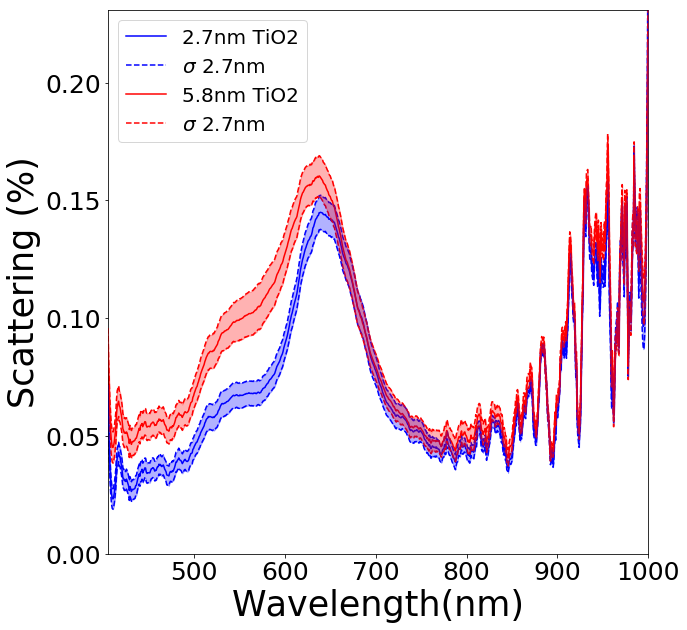

In [153]:
# Plot the average values of all spectra

fig3=plt.figure(3, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax5=fig3.add_subplot(111)

#
#ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100, color = "blue", label = "2.7nm Titania")
#ax5.plot(wavelength_store_2_7nm_1[0], av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, '--', color = "blue", label = "$\sigma$ 2.7nm ")
#ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100, '--', color = "blue")
#ax5.fill_between(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100,
#                av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, color = "blue", 
#                alpha = 0.3, zorder = 3)

ax5.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100, color = "blue", label = "2.7nm TiO2")
ax5.plot(wavelength_store_2_7nm[0], av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, '--', color = "blue", label = "$\sigma$ 2.7nm ")
ax5.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100, '--', color = "blue")
ax5.fill_between(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100,
                av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, color = "blue", 
                alpha = 0.3, zorder = 3)

ax5.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100, color = "red", label = "5.8nm TiO2")
ax5.plot(wavelength_store_5_8nm[0], av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, '--', color = "red", label = "$\sigma$ 2.7nm ")
ax5.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100, '--', color = "red")
ax5.fill_between(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100,
                av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax5.legend(loc = "best", prop={'size': 20})
ax5.tick_params(axis='x', labelsize=25)
ax5.tick_params(axis='y', labelsize=25)
ax5.set_xlabel("Wavelength(nm)", fontsize = 35)
ax5.set_ylabel("Scattering (%)", fontsize = 35)
ax5.set_ylim([0, max(average_all_intensities_2_7nm*100)*1])
ax5.set_xlim([min(wavelength_store_2_7nm[0]), max(wavelength_store_2_7nm[0])])
# ax6.set_title(fname[slash_loc:-3] + "\n Averaged spectra", 
#               fontsize = 18, y=1.2)

#ax5.set_xlim(ax6.get_xlim())
#ax5.set_xticks(new_tick_locations)
#ax5.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax5.set_xlabel(r"Energy(eV)", fontsize = 13)

#ax6.set_ylabel("Bright Field Intensity (A.U.)", fontsize = 16)

fig3.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7_5.8nmTiO2.png")

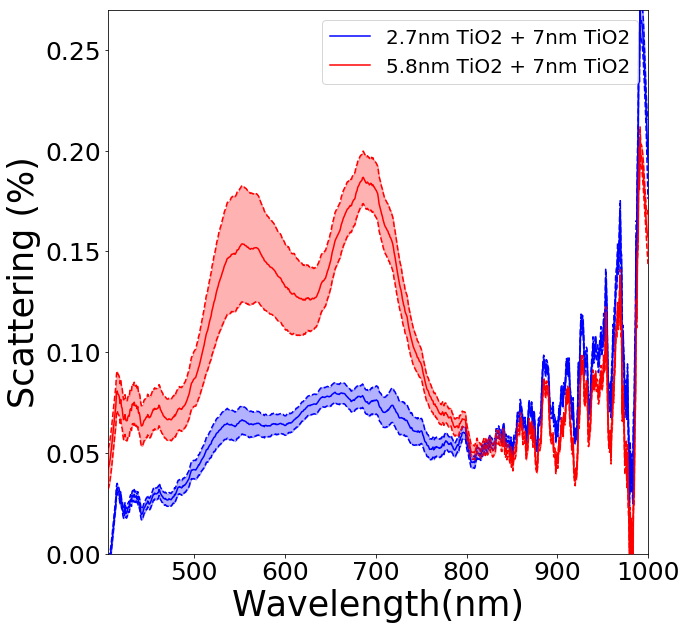

In [152]:
# Plot the average values of all spectra

fig3=plt.figure(3, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax5=fig3.add_subplot(111)

#
#ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100, color = "blue", label = "2.7nm Titania")
#ax5.plot(wavelength_store_2_7nm_1[0], av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, '--', color = "blue", label = "$\sigma$ 2.7nm ")
#ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100, '--', color = "blue")
#ax5.fill_between(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100,
#                av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, color = "blue", 
#                alpha = 0.3, zorder = 3)

ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100, color = "blue", label = "2.7nm TiO2 + 7nm TiO2")
ax5.plot(wavelength_store_2_7nm_1[0], av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, '--', color = "blue")
ax5.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100, '--', color = "blue")
ax5.fill_between(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100,
                av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, color = "blue", 
                alpha = 0.3, zorder = 3)

ax5.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100, color = "red", label = "5.8nm TiO2 + 7nm TiO2")
ax5.plot(wavelength_store_5_8nm_1[0], av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, '--', color = "red")
ax5.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100, '--', color = "red")
ax5.fill_between(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100,
                av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax5.legend(loc = "best", prop={'size': 20})
ax5.tick_params(axis='x', labelsize=25)
ax5.tick_params(axis='y', labelsize=25)
ax5.set_xlabel("Wavelength(nm)", fontsize = 35)
ax5.set_ylabel("Scattering (%)", fontsize = 35)
ax5.set_ylim([0, max(average_all_intensities_2_7nm_1*100)*1])
ax5.set_xlim([min(wavelength_store_2_7nm_1[0]), max(wavelength_store_2_7nm_1[0])])
# ax6.set_title(fname[slash_loc:-3] + "\n Averaged spectra", 
#               fontsize = 18, y=1.2)

#ax5.set_xlim(ax6.get_xlim())
#ax5.set_xticks(new_tick_locations)
#ax5.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax5.set_xlabel(r"Energy(eV)", fontsize = 13)

#ax6.set_ylabel("Bright Field Intensity (A.U.)", fontsize = 16)

fig3.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7_5.8nmTiO2 with 7nm TiO2.png")

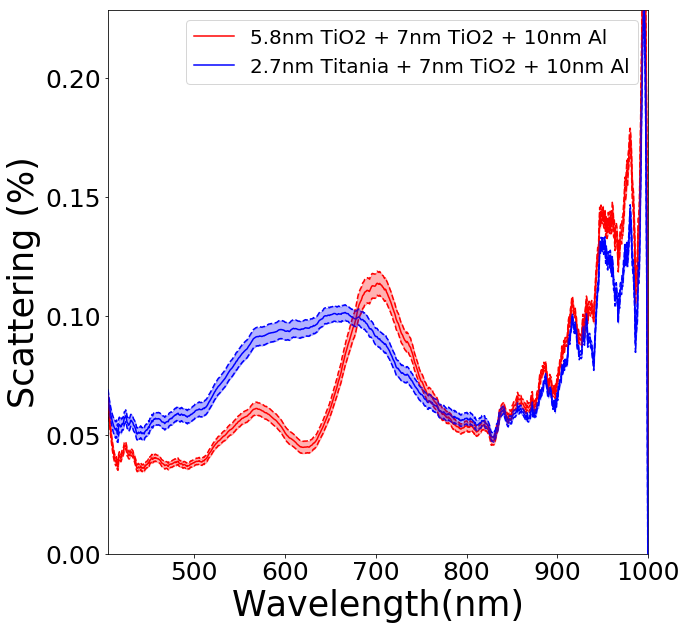

In [151]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)
#ax5 = ax4.twiny()
ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100, "red", label = "5.8nm TiO2 + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_5_8nm_Al[0], av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, '--', color = "red")
ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100, '--' , color = "red")
ax4.fill_between(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100,
                av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, color = "red", 
                alpha = 0.3, zorder = 3)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100, color = "blue", label = "2.7nm Titania + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_2_7nm_Al[0], av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, '--', color = "blue")
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100, '--', color = "blue")
ax4.fill_between(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100,
                av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, color = "blue", 
                alpha = 0.3, zorder = 3)


ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Al*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Al[0]), max(wavelength_store_2_7nm_Al[0])])
# ax6.set_title(fname[slash_loc:-3] + "\n Averaged spectra", 
#               fontsize = 18, y=1.2)

#ax5.set_xlim(ax6.get_xlim())
#ax5.set_xticks(new_tick_locations)
#ax5.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax5.set_xlabel(r"Energy(eV)", fontsize = 13)

#ax6.set_ylabel("Bright Field Intensity (A.U.)", fontsize = 16)

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7_5.8nmTiO2 with 7nm TiO2 and 10nm Al.png")

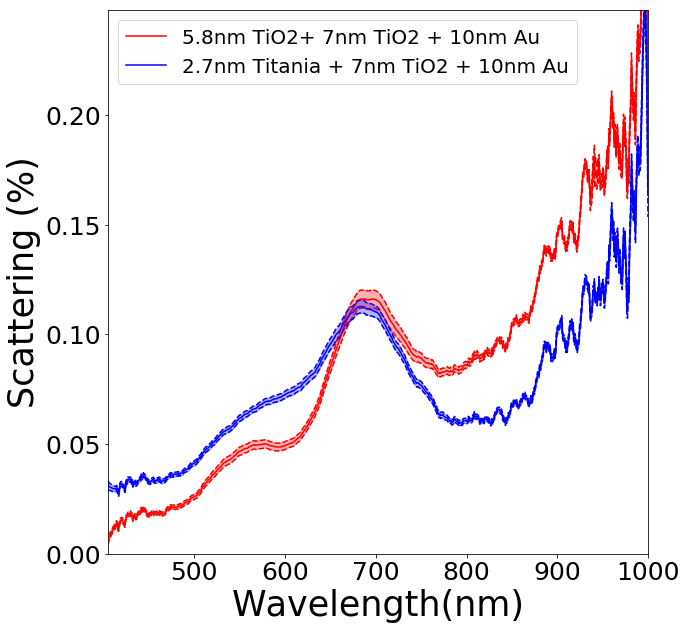

In [150]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)
#ax5 = ax4.twiny()
ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100, "red", label = "5.8nm TiO2+ 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_5_8nm_Au[0], av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, '--', color = "red")
ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100, '--' , color = "red")
ax4.fill_between(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100,
                av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, color = "red", 
                alpha = 0.3, zorder = 3)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100, color = "blue", label = "2.7nm Titania + 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_2_7nm_Au[0], av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, '--', color = "blue")
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100, '--', color = "blue")
ax4.fill_between(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100,
                av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, color = "blue", 
                alpha = 0.3, zorder = 3)


ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Au[0]), max(wavelength_store_2_7nm_Au[0])])
# ax6.set_title(fname[slash_loc:-3] + "\n Averaged spectra", 
#               fontsize = 18, y=1.2)

#ax5.set_xlim(ax6.get_xlim())
#ax5.set_xticks(new_tick_locations)
#ax5.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax5.set_xlabel(r"Energy(eV)", fontsize = 13)

#ax6.set_ylabel("Bright Field Intensity (A.U.)", fontsize = 16)

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7_5.8nmTiO2 with 7nm TiO2 and 10nm Au.png")

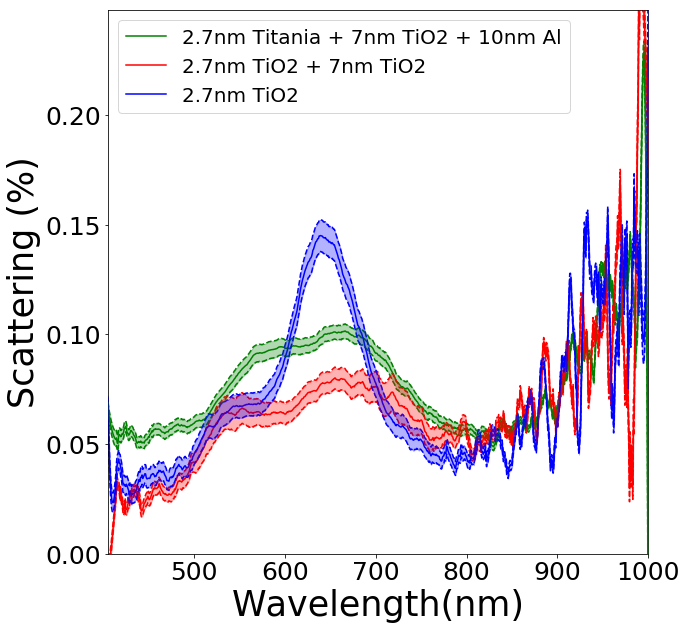

In [149]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100, color = "green", label = "2.7nm Titania + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_2_7nm_Al[0], av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, '--', color = "green")
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100, '--', color = "green")
ax4.fill_between(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100,
                av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, color = "green", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100, color = "red", label = "2.7nm TiO2 + 7nm TiO2")
ax4.plot(wavelength_store_2_7nm_1[0], av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, '--', color = "red")
ax4.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100, '--', color = "red")
ax4.fill_between(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100,
                av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100, color = "blue", label = "2.7nm TiO2")
ax4.plot(wavelength_store_2_7nm[0], av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, '--', color = "blue")
ax4.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100, '--', color = "blue")
ax4.fill_between(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100,
                av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, color = "blue", 
                alpha = 0.3, zorder = 3)



ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Au[0]), max(wavelength_store_2_7nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7nm_all_stages.png")

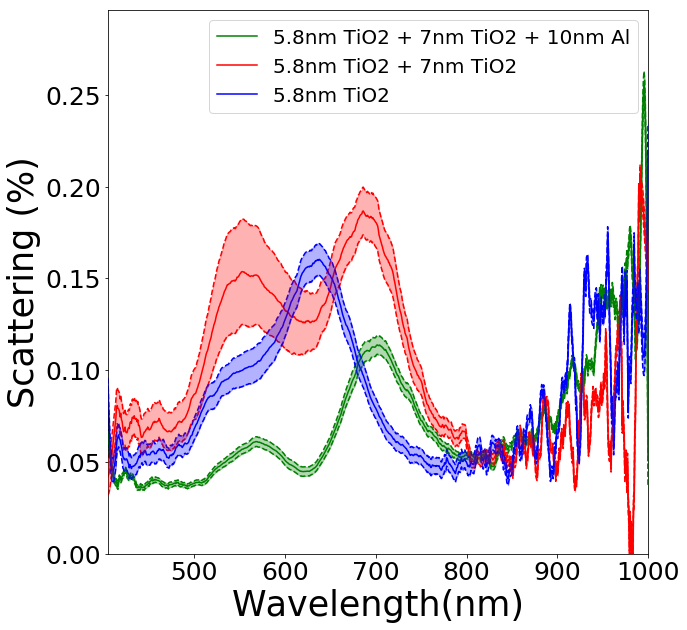

In [148]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100, "green", label = "5.8nm TiO2 + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_5_8nm_Al[0], av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, '--', color = "green")
ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100, '--' , color = "green")
ax4.fill_between(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100,
                av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, color = "green", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100, color = "red", label = "5.8nm TiO2 + 7nm TiO2")
ax4.plot(wavelength_store_5_8nm_1[0], av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, '--', color = "red")
ax4.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100, '--', color = "red")
ax4.fill_between(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100,
                av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100, color = "blue", label = "5.8nm TiO2")
ax4.plot(wavelength_store_5_8nm[0], av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, '--', color = "blue")
ax4.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100, '--', color = "blue")
ax4.fill_between(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100,
                av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, color = "blue", 
                alpha = 0.3, zorder = 3)

ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_5_8nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_5_8nm_Au[0]), max(wavelength_store_5_8nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp5.8nm_all_stages.png")

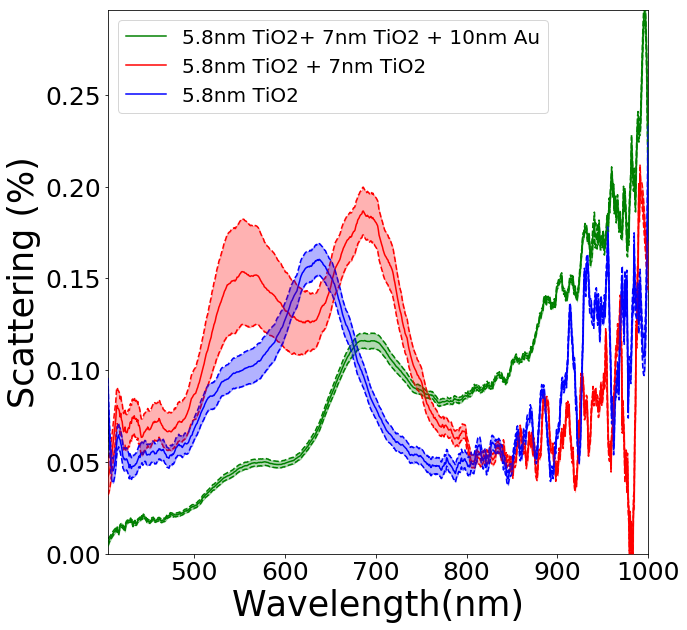

In [147]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100, "green", label = "5.8nm TiO2+ 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_5_8nm_Au[0], av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, '--', color = "green")
ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100, '--' , color = "green")
ax4.fill_between(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100,
                av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, color = "green", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100, color = "red", label = "5.8nm TiO2 + 7nm TiO2")
ax4.plot(wavelength_store_5_8nm_1[0], av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, '--', color = "red")
ax4.plot(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100, '--', color = "red")
ax4.fill_between(wavelength_store_5_8nm_1[0], average_all_intensities_5_8nm_1*100 - av_stddev_5_8nm_1*100,
                av_stddev_5_8nm_1*100 + average_all_intensities_5_8nm_1*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100, color = "blue", label = "5.8nm TiO2")
ax4.plot(wavelength_store_5_8nm[0], av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, '--', color = "blue")
ax4.plot(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100, '--', color = "blue")
ax4.fill_between(wavelength_store_5_8nm[0], average_all_intensities_5_8nm*100 - av_stddev_5_8nm*100,
                av_stddev_5_8nm*100 + average_all_intensities_5_8nm*100, color = "blue", 
                alpha = 0.3, zorder = 3)

ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_5_8nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_5_8nm_Au[0]), max(wavelength_store_5_8nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_5.8nm_all_Au.png")

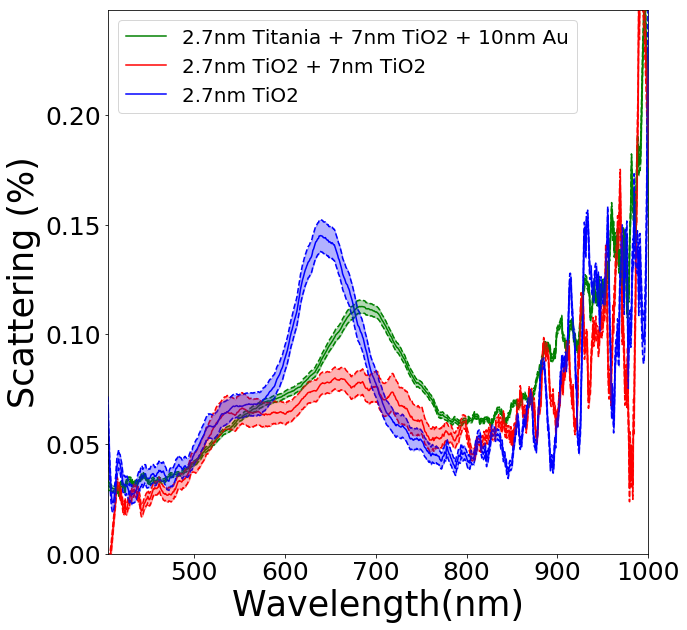

In [154]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100, color = "green", label = "2.7nm Titania + 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_2_7nm_Au[0], av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, '--', color = "green")
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100, '--', color = "green")
ax4.fill_between(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100,
                av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, color = "green", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100, color = "red", label = "2.7nm TiO2 + 7nm TiO2")
ax4.plot(wavelength_store_2_7nm_1[0], av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, '--', color = "red")
ax4.plot(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100, '--', color = "red")
ax4.fill_between(wavelength_store_2_7nm_1[0], average_all_intensities_2_7nm_1*100 - av_stddev_2_7nm_1*100,
                av_stddev_2_7nm_1*100 + average_all_intensities_2_7nm_1*100, color = "red", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100, color = "blue", label = "2.7nm TiO2")
ax4.plot(wavelength_store_2_7nm[0], av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, '--', color = "blue")
ax4.plot(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100, '--', color = "blue")
ax4.fill_between(wavelength_store_2_7nm[0], average_all_intensities_2_7nm*100 - av_stddev_2_7nm*100,
                av_stddev_2_7nm*100 + average_all_intensities_2_7nm*100, color = "blue", 
                alpha = 0.3, zorder = 3)



ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Au[0]), max(wavelength_store_2_7nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7nm_all_Au.png")

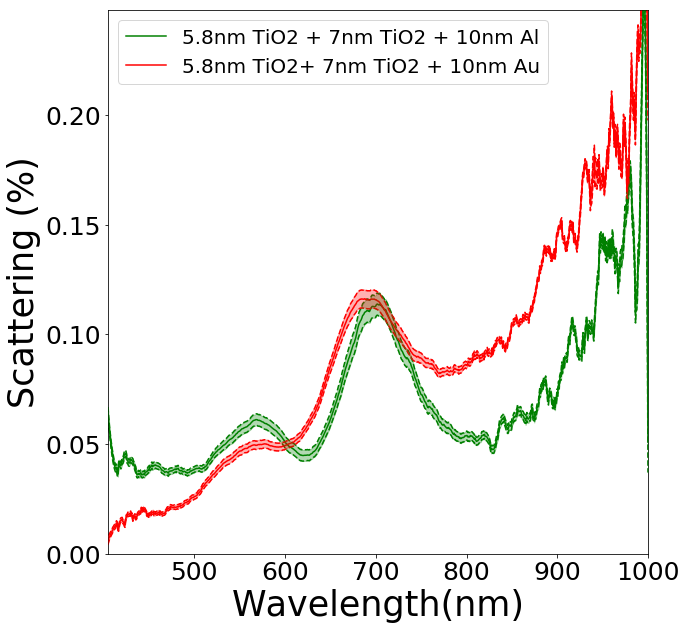

In [145]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100, "green", label = "5.8nm TiO2 + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_5_8nm_Al[0], av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, '--', color = "green")
ax4.plot(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100, '--' , color = "green")
ax4.fill_between(wavelength_store_5_8nm_Al[0], average_all_intensities_5_8nm_Al*100 - av_stddev_5_8nm_Al*100,
                av_stddev_5_8nm_Al*100 + average_all_intensities_5_8nm_Al*100, color = "green", 
                alpha = 0.3, zorder = 3)

ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100, "red", label = "5.8nm TiO2+ 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_5_8nm_Au[0], av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, '--', color = "red")
ax4.plot(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100, '--' , color = "red")
ax4.fill_between(wavelength_store_5_8nm_Au[0], average_all_intensities_5_8nm_Au*100 - av_stddev_5_8nm_Au*100,
                av_stddev_5_8nm_Au*100 + average_all_intensities_5_8nm_Au*100, color = "red", 
                alpha = 0.3, zorder = 3)


ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Au[0]), max(wavelength_store_2_7nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_5.8nm_Au_Al.png")

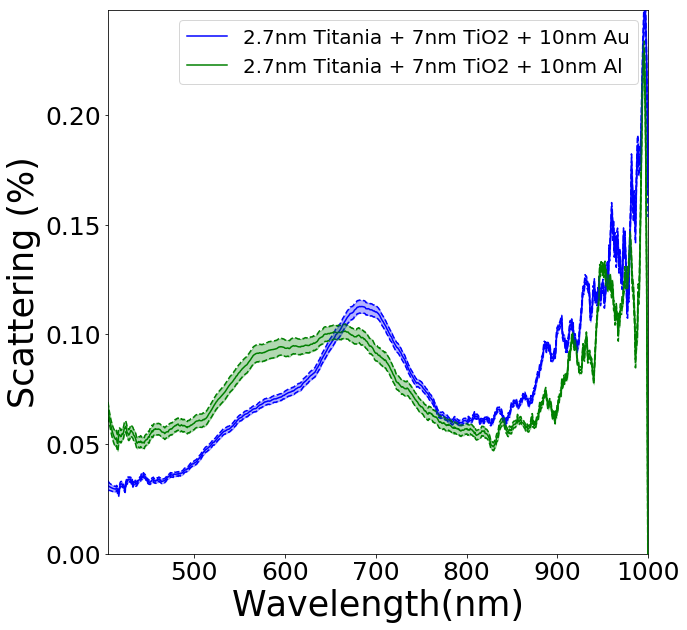

In [144]:
# Plot the average values of all spectra

#Plot green terrace DF from NPs
fig2=plt.figure(2, figsize = (10, 10))
plt.gcf().subplots_adjust(left = 0.15)
ax4=fig2.add_subplot(111)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100, color = "blue", label = "2.7nm Titania + 7nm TiO2 + 10nm Au")
ax4.plot(wavelength_store_2_7nm_Au[0], av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, '--', color = "blue")
ax4.plot(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100, '--', color = "blue")
ax4.fill_between(wavelength_store_2_7nm_Au[0], average_all_intensities_2_7nm_Au*100 - av_stddev_2_7nm_Au*100,
                av_stddev_2_7nm_Au*100 + average_all_intensities_2_7nm_Au*100, color = "blue", 
                alpha = 0.3, zorder = 3)

#Plot orange terrace DF from NPs
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100, color = "green", label = "2.7nm Titania + 7nm TiO2 + 10nm Al")
ax4.plot(wavelength_store_2_7nm_Al[0], av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, '--', color = "green")
ax4.plot(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100, '--', color = "green")
ax4.fill_between(wavelength_store_2_7nm_Al[0], average_all_intensities_2_7nm_Al*100 - av_stddev_2_7nm_Al*100,
                av_stddev_2_7nm_Al*100 + average_all_intensities_2_7nm_Al*100, color = "green", 
                alpha = 0.3, zorder = 3)


ax4.legend(loc = "best", prop={'size': 20})
ax4.tick_params(axis='x', labelsize=25)
ax4.tick_params(axis='y', labelsize=25)
ax4.set_xlabel("Wavelength(nm)", fontsize = 35)
ax4.set_ylabel("Scattering (%)", fontsize = 35)
ax4.set_ylim([0, max(average_all_intensities_2_7nm_Au*100)*1])
ax4.set_xlim([min(wavelength_store_2_7nm_Au[0]), max(wavelength_store_2_7nm_Au[0])])

fig2.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/Comp_2.7nm_Au_Al.png")

In [ ]:
#Find peaks in the data

peakfind_start = 401
wavelength_start = 400
wavelength_end = 1000
data_start = (np.abs(wavelength_store_g[0] - wavelength_start)).argmin()
data_end = (np.abs(wavelength_store_g[0] - wavelength_end)).argmin()

peak_data_start = (np.abs(wavelength_store_g[0] - peakfind_start)).argmin()

peak_indexes_av_g = peakutils.indexes(average_all_intensities_g[peak_data_start:data_end], 
                                                 thres = 0.05, 
                                                 min_dist = 50*2)

peak_indexes_av_o = peakutils.indexes(average_all_intensities_o[peak_data_start:data_end], 
                                                 thres = 0.05, 
                                                 min_dist = 50*2)

print peak_indexes_av_g
print wavelength_store_g[0][216]
print wavelength_store_g[0][474]
print 1/(average_all_intensities_g[216]/average_all_intensities_g[474])

print peak_indexes_av_o
print wavelength_store_o[0][187]
print wavelength_store_o[0][386]
print 1/(average_all_intensities_o[187]/average_all_intensities_o[386])

peak_sep_o = wavelength_store_o[0][386] - wavelength_store_o[0][187]
print peak_sep_o

peak_sep_g = wavelength_store_g[0][474] - wavelength_store_g[0][216]
print peak_sep_g

In [ ]:
#Clustering data



In [16]:
#need to ignore transverse mode for peak sorting, so sort by coupled modes instead

sorted_array_5_8nm = Alex_data.sort_coupled_modes(intensity_store_norm_5_8nm, 
                                            peak_wavelengths_store_5_8nm)
sorted_pk_intensities_5_8nm = Alex_data.sort_coupled_modes(peak_intensities_store_5_8nm, 
                                                     peak_wavelengths_store_5_8nm)



sorted_peak_wls_5_8nm = []
for i in range(0, len(sorted_array_5_8nm)):
    sorted_peak_wls_5_8nm.append(sorted_array_5_8nm[i][len(intensity_store_norm_5_8nm[0]):])
sorted_peak_wls_5_8nm = np.array(sorted_peak_wls_5_8nm[:-1])

while len(sorted_array_5_8nm[1]) > len(wavelength_store_5_8nm[0]):
    sorted_array_5_8nm = np.delete(sorted_array_5_8nm, [len(wavelength_store_5_8nm[0])], 1)
    
while len(sorted_pk_intensities_5_8nm[1]) > len(peak_index_store_5_8nm[0]):    
    sorted_pk_intensities_5_8nm = np.delete(sorted_pk_intensities_5_8nm, [len(peak_index_store_5_8nm[0])], 1) 
    
#Use function to add offset between each spectrum
sorted_array_offset_5_8nm = Alex_plot.offset_spectra(sorted_array_5_8nm)
sorted_pks_offset_5_8nm = Alex_plot.offset_spectra(sorted_pk_intensities_5_8nm)

In [34]:
#need to ignore transverse mode for peak sorting, so sort by coupled modes instead

sorted_array_5_8nm_1 = Alex_data.sort_coupled_modes(intensity_store_norm_5_8nm_1, 
                                            peak_wavelengths_store_5_8nm_1)
sorted_pk_intensities_5_8nm_1 = Alex_data.sort_coupled_modes(peak_intensities_store_5_8nm_1, 
                                                     peak_wavelengths_store_5_8nm_1)



sorted_peak_wls_5_8nm_1 = []
for i in range(0, len(sorted_array_5_8nm_1)):
    sorted_peak_wls_5_8nm_1.append(sorted_array_5_8nm_1[i][len(intensity_store_norm_5_8nm_1[0]):])
sorted_peak_wls_5_8nm_1 = np.array(sorted_peak_wls_5_8nm_1[:-1])

while len(sorted_array_5_8nm_1[1]) > len(wavelength_store_5_8nm_1[0]):
    sorted_array_5_8nm_1 = np.delete(sorted_array_5_8nm_1, [len(wavelength_store_5_8nm_1[0])], 1)
    
while len(sorted_pk_intensities_5_8nm_1[1]) > len(peak_index_store_5_8nm_1[0]):    
    sorted_pk_intensities_5_8nm_1 = np.delete(sorted_pk_intensities_5_8nm_1, [len(peak_index_store_5_8nm_1[0])], 1) 
    
#Use function to add offset between each spectrum
sorted_array_offset_5_8nm_1 = Alex_plot.offset_spectra(sorted_array_5_8nm_1)
sorted_pks_offset_5_8nm_1 = Alex_plot.offset_spectra(sorted_pk_intensities_5_8nm_1)

Text(0,0.5,u'Spectrum_no + Intensity (A.U)')

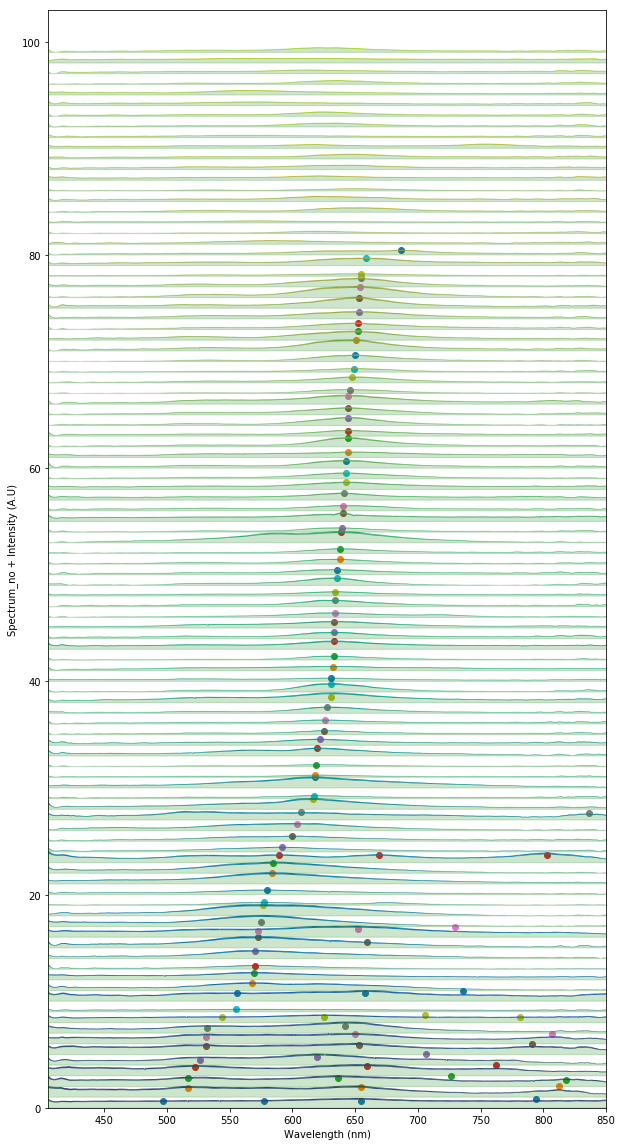

In [17]:
fig3 = plt.figure(3, figsize = (10,0.2*len(sorted_array_offset_5_8nm)))
ax7 = fig3.add_subplot(111)
#ax10 = ax8.twiny()
#ax10.set_xlim(ax6.get_xlim())
#ax10.set_xticks(new_tick_locations)
#ax10.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax10.set_xlabel(r"Energy(eV)")


colours = parula_map(np.linspace(0,1,len(sorted_array_offset_5_8nm)))
for i in range(0, len(sorted_array_offset_5_8nm)-1):
    lwidths = (sorted_array_offset_5_8nm[i] - i)*2
    points = np.array([wavelength_store_5_8nm[0], sorted_array_offset_5_8nm[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax7.add_collection(lc_2)
    spec1 = np.array(sorted_array_offset_5_8nm[i], dtype = float)
    spec2 = np.array(len(sorted_array_offset_5_8nm[i])*[i], dtype = float)
    ax7.fill_between(wavelength_store_5_8nm[0], spec1, spec2, color = "green", 
                alpha = 0.2, zorder = 3)
    ax7.scatter(sorted_peak_wls_5_8nm[i], np.full((1,7), sorted_pks_offset_5_8nm[i]))


ax7.set_ylim(0, len(sorted_array_offset_5_8nm) + 2)
ax7.set_xlim(405, 850)
ax7.set_xlabel("Wavelength (nm)")
ax7.set_ylabel("Spectrum_no + Intensity (A.U)")



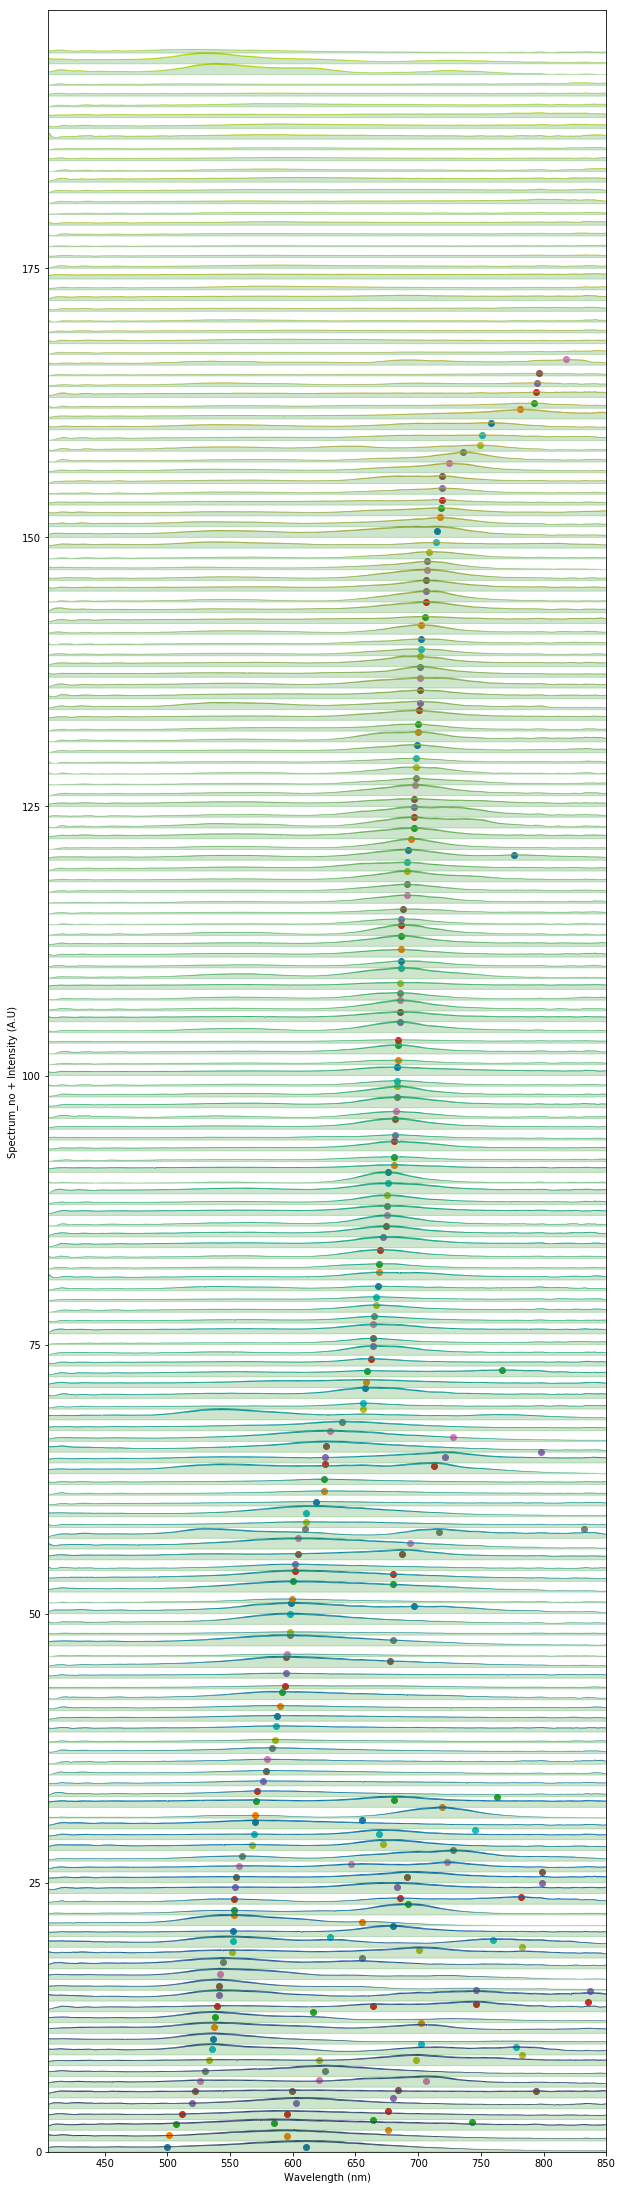

In [39]:
fig3 = plt.figure(3, figsize = (10,0.2*len(sorted_array_offset_5_8nm_1)))
ax7 = fig3.add_subplot(111)
#ax10 = ax8.twiny()
#ax10.set_xlim(ax6.get_xlim())
#ax10.set_xticks(new_tick_locations)
#ax10.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax10.set_xlabel(r"Energy(eV)")


colours = parula_map(np.linspace(0,1,len(sorted_array_offset_5_8nm_1)))
for i in range(0, len(sorted_array_offset_5_8nm_1)-1):
    lwidths = (sorted_array_offset_5_8nm_1[i] - i)*2
    points = np.array([wavelength_store_5_8nm_1[0], sorted_array_offset_5_8nm_1[i]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis = 1)
    lc_2 = LineCollection(segments, linewidths = lwidths, color = colours[i])
    ax7.add_collection(lc_2)
    spec1 = np.array(sorted_array_offset_5_8nm_1[i], dtype = float)
    spec2 = np.array(len(sorted_array_offset_5_8nm_1[i])*[i], dtype = float)
    ax7.fill_between(wavelength_store_5_8nm_1[0], spec1, spec2, color = "green", 
                alpha = 0.2, zorder = 3)
    ax7.scatter(sorted_peak_wls_5_8nm_1[i], np.full((1,7), sorted_pks_offset_5_8nm_1[i]))


ax7.set_ylim(0, len(sorted_array_offset_5_8nm_1) + 2)
ax7.set_xlim(405, 850)
ax7.set_xlabel("Wavelength (nm)")
ax7.set_ylabel("Spectrum_no + Intensity (A.U)")

fig3.savefig("C:/Users/alexc/OneDrive - University Of Cambridge/Documents/PhD Project/Projects/Hot electron resonator/5.8nmTiO2 overview with 7nm TiO2.png")

C:\Users\alexc\Anaconda2\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(18.1063,0.5,u'Spectrum number')

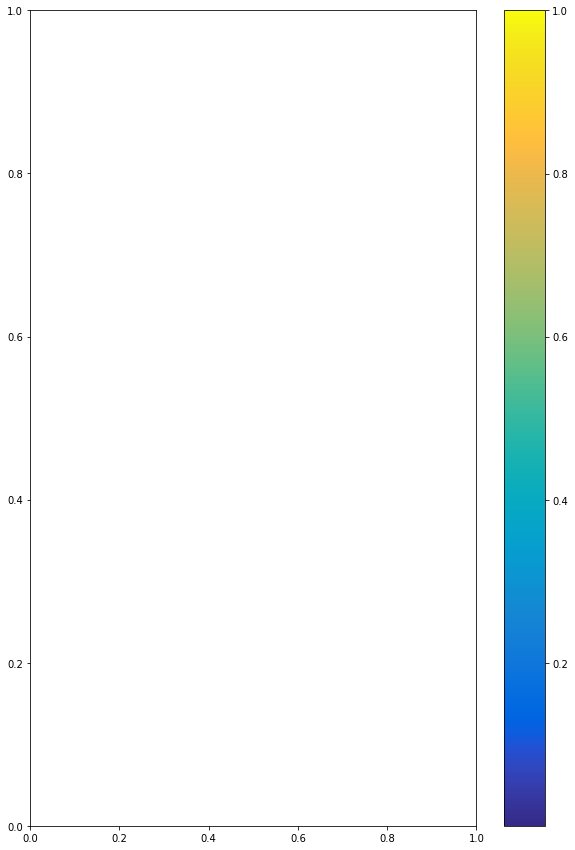

In [18]:


#plot map of sorted spectra

fig4=plt.figure(4, figsize = (10, 15))
ax8=fig3.add_subplot(111)

all_sorted_array_5_8nm = np.array(sorted_array_5_8nm, dtype=float)

mapfig1 = ax8.imshow(all_sorted_array_5_8nm, 
                    extent=[400, 850,
                    0, len(all_sorted_array_5_8nm)], aspect = 'auto', 
                            cmap = parula_map, vmin = min(average_all_intensities_5_8nm))
                            
fig4.colorbar(mapfig1)
ax8.tick_params(axis='x', labelsize=16)
ax8.tick_params(axis='y', labelsize=16)
ax8.set_xlabel("Wavelength(nm)", fontsize = 16)
ax8.set_ylabel("Spectrum number", fontsize = 16)
#ax8.set_title(fname[slash_loc:-3] + "\nNormalised DF sorted by peak position", 
 #             fontsize = 18, y=1.2)
#ax11 = ax3.twiny()
#ax11.set_xlim(ax6.get_xlim())
#ax11.set_xticks(new_tick_locations)
#ax11.set_xticklabels(Alex_plot.energy_ticks(new_tick_locations))
#ax11.set_xlabel(r"Energy(eV)")